# Homework 6 - Generative Adversarial Network
- 建立一个生成性的对抗网络来生成动画人脸

## Import

In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Dataset
- Resize the images to (64, 64)
- Linearly map the values from [0, 1] to [-1, 1].

In [2]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform = None):
        if  transform:
            self.transform = transform
        else:
            self.transform= transforms.Compose([ transforms.ToPILImage(),    transforms.Resize((64, 64)),
                transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ])    
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

### Show sone images
- 请注意，这些值在[-1,1]范围内，我们应该将它们移到有效范围[0,1]，以便正确显示

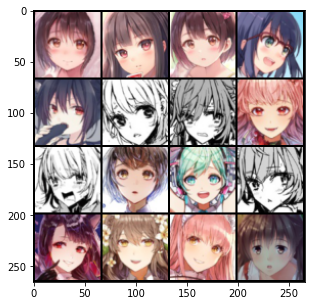

In [6]:
dataset = CrypkoDataset(glob.glob("./data/faces/*"))
#(dataset[i]+1)/2---------[-1,1]->[0,1]
images = [(dataset[i]+1)/2  for i in range(16)]    
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(5,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
- 使用DCGAN作为模型结构。请随意修改您自己的模型结构

### Generator

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential( nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                    padding=2, output_padding=1, bias=False),nn.BatchNorm2d(out_dim),nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(in_dim, dim*8*4*4,bias=False),nn.BatchNorm1d(dim * 8 * 4 * 4),nn.ReLU())
        self.l2_5 = nn.Sequential(dconv_bn_relu(dim * 8, dim * 4), dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim), nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1), nn.Tanh())
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

### Discriminator

In [3]:
class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )
            
        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid(), 
        )
        self.apply(weights_init)
        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

## Training

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

In [7]:
# Training hyperparameters  Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 
batch_size ,z_dim,lr ,n_epoch,n_critic= 64,100, 1e-4,1,1
z_sample = Variable(torch.randn(100, z_dim)).cuda()
# clip_value = 0.01
os.makedirs("./logs/", exist_ok=True)
os.makedirs("./checkpoints/", exist_ok=True)
# Model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()
# Loss
criterion = nn.BCELoss()
""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

### Training loop
- 定期存储一些图片以监控生成器的当前性能，并定期记录检查点

In [8]:
steps = 0
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = tqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda()
        bs = imgs.size(0)
        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        """ Medium: Use WGAN Loss. """
        # Label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # Model forwarding
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        
        # Compute the loss for the discriminator.
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        # loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))
       

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        """ Medium: Clip weights of discriminator. """
        # for p in D.parameters():
        #    p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_imgs = G(z)

            # Model forwarding
            f_logit = D(f_imgs)
            
            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            # loss_G = -torch.mean(D(f_imgs))

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1,
            'Step': steps,
        })

    
    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join("./logs/", f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    
    # Show generated images in the jupyter notebook.
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    if (e+1) % 5 == 0 or e == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), "./checkpoints/G.pth")
        torch.save(D.state_dict(), "./checkpoints/D.pth")



 Iters     Elapsed Time      Speed                                              
 0/1115          -             -                                                

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [9]:
for i, data in enumerate(dataloader):
    imgs = data
    print(imgs.shape)
    break